In [122]:
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt
import napari

In [123]:
from segment_anything import sam_model_registry
from segment_anything.automatic_mask_generator import SamAutomaticMaskGenerator
from ultralytics.models.sam import Predictor as SAMPredictor
from tnia.deeplearning.sam_helper import get_sam_predictor, get_sam
predictor = get_sam_predictor('vit_b')

(640, 640, 3)


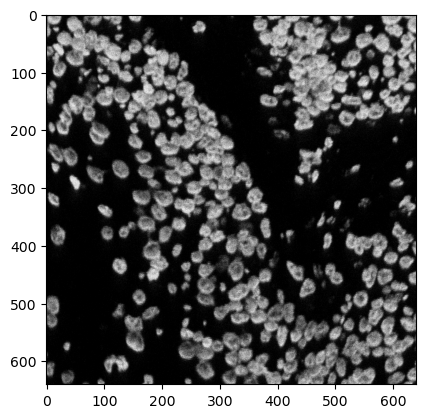

In [124]:

tnia_images_path = Path("D:/images/tnia-python-images")
parent_path = tnia_images_path / "imagesc/2024_03_08_flower_like"
image = imread(str(parent_path / ("HP_1week_screenshot.jpg")))

parent_path=Path(tnia_images_path / r'imagesc/2024_03_21_nuclei_segmentation')
#image = imread(str(parent_path / ("leaf.jpg")))
image = imread(str(parent_path / ("2023-03-28T14-12-32_Alessio_Pilot_Run_8bit.tif")))

if image.ndim == 2:
    rgb = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    rgb[:,:,0] = image
    rgb[:,:,1] = image
    rgb[:,:,2] = image
    image = rgb

print(image.shape)
tnia_images_path = Path(r"D:\images")
plt.imshow(image)

In [125]:
sam = get_sam('vit_b')
sam_anything_predictor = SamAutomaticMaskGenerator(sam,
        #points_per_side=int(self.le_points_per_side.text()),
        #points_per_batch=int(self.le_points_per_batch.text()),
        pred_iou_thresh=0.1,
        stability_score_thresh=0.1,
        #stability_score_offset=float(self.le_stability_score_offset.text()),
        #box_nms_thresh=float(self.le_box_nms_thresh.text()),
        #crop_n_layers=int(self.le_crop_n_layers.text()),
        #crop_nms_thresh=float(self.le_crop_nms_thresh.text()),
        #crop_overlap_ratio=float(self.le_crop_overlap_ratio.text()),
        #crop_n_points_downscale_factor=int(self.le_crop_n_points_downscale_factor.text()),
        #min_mask_region_area=int(self.le_min_mask_region_area.text()),
        )

In [126]:
results = sam_anything_predictor.generate(image)

In [128]:
# read back the results
with (open(parent_path / "results.pkl", "rb")) as f:
    results354 = pickle.load(f)

In [139]:
n=1
for result in results:
    result['label_num']=n
    n=n+1

In [140]:
project = {}
project['image'] = image
project['results'] = results
for result in results:
    result['keep'] = True
import pickle
## use the pickle
with open(parent_path / 'project.pkl', 'wb') as f:
    pickle.dump(project, f)

In [137]:
from tnia.deeplearning.sam_helper import make_label_image_3d

results = sorted(results, key=lambda x: x['area'], reverse=True)
label_image = make_label_image_3d(results)

In [64]:
for result in sorted_results:
    result['keep'] = True

print(results[34])

{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 557, 'bbox': [580, 0, 36, 18], 'predicted_iou': 0.9664323329925537, 'point_coords': [[610.0, 10.0]], 'stability_score': 0.9804270267486572, 'crop_box': [0, 0, 640, 640], 'keep': True}


In [99]:
import napari
viewer = napari.Viewer()
viewer.add_image(image)
viewer.add_labels(label_image)

<Labels layer 'label_image' at 0x21897d4b7f0>

In [20]:
import numpy as np
print(results[10]['segmentation'].shape)
print(label_image.shape)

(446, 507)
(149, 446, 507)


In [86]:
#help(viewer.layers[1])


TypeError: Labels.fill() missing 2 required positional arguments: 'coord' and 'new_label'

In [90]:
help(viewer.layers[1].fill)

Help on method fill in module napari.layers.labels.labels:

fill(coord, new_label, refresh=True) method of napari.layers.labels.labels.Labels instance
    Replace an existing label with a new label, either just at the
    connected component if the `contiguous` flag is `True` or everywhere
    if it is `False`, working in the number of dimensions specified by
    the `n_edit_dimensions` flag.
    
    Parameters
    ----------
    coord : sequence of float
        Position of mouse cursor in image coordinates.
    new_label : int
        Value of the new label to be filled in.
    refresh : bool
        Whether to refresh view slice or not. Set to False to batch paint
        calls.



In [110]:
type(coords[0])

numpy.ndarray

In [120]:
result = results[0]


for enum, result in enumerate(sorted_results):
    coords = np.where(result['segmentation'])
    
    z = np.full(coords[0].shape, enum)
    coords = (z, coords[0], coords[1])
    if enum < label_image.shape[0]-1:
        viewer.layers[1].data_setitem(coords, 0, False)
    else:
        viewer.layers[1].data_setitem(coords, 0, False)
    #viewer.layers[1].fill((enum,point[0][1],point[0][0]), 0, True)




In [121]:
viewer.layers[1].refresh()

In [88]:
#shape, dims_to_paint = viewer.layers[1]._get_shape_and_dims_to_paint()


#viewer.layers[1].labels.paint_polygon(coords, 48, refresh=True)
#viewer.layers[1].g

'''
viewer.layers[1]._paint_indices(
        coords,
        48,
        None, #shape,
        None, #dims_to_paint,
        slice_coord=None,
        refresh=True)
'''

[[130.0, 270.0]]


'\nviewer.layers[1]._paint_indices(\n        coords,\n        48,\n        None, #shape,\n        None, #dims_to_paint,\n        slice_coord=None,\n        refresh=True)\n'

In [53]:
max_area = 10000000000
min_area = 0

for enum, result in enumerate(sorted_results):
    if result['area'] < min_area or result['area'] > max_area:
        if result['keep']==False:
            continue
        result['keep'] = False
        coords = np.where(result['segmentation'])
        temp = label_image[enum, :,:]
        temp[coords] = 0
    else:
        if result['keep']==True:
            continue
        result['keep'] = True
        coords = np.where(result['segmentation'])
        temp = label_image[enum, :,:]
        temp[coords] = enum+1

viewer.layers[1].data=viewer.layers[1].data

In [35]:
label_image.sum()

3291541

In [23]:
label_image.sum()

12691016

In [51]:
test3=label_image.max(axis=0)

In [48]:
label_image.shape

slice_list=[11, 12, 14, 15, 19, 21, 100, 109, 122, 133]

test = label_image[slice_list]

test2=test.max(axis=0)


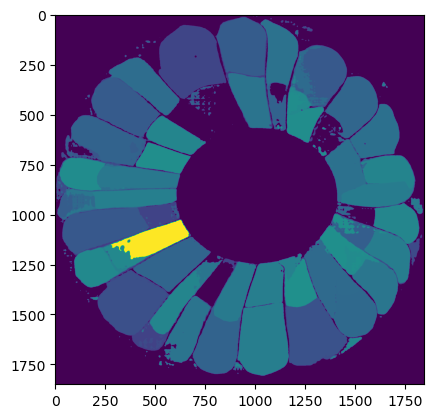

In [52]:
plt.imshow(test3)

In [44]:
viewer = napari.Viewer()
viewer.add_image(image, name="image")
viewer.add_labels(label_image, name="labels")

<Labels layer 'labels' at 0x173c790dd80>

In [40]:
viewer.layers[0].fill((120,1155,450), 300, True)

In [35]:
viewer.layers[0].data[label_image==65]=0
viewer.layers[0].data=viewer.layers[0].data

In [28]:
viewer.

(242, 1850, 1848)

In [31]:
label_image[150:,:,:] = 0

In [24]:
"""
Display a 3D image (plus labels) with a clipping plane and interactive controls
for moving the plane
"""
import napari
import numpy as np
from skimage import data
from scipy import ndimage

viewer = napari.Viewer(ndisplay=3)

labeled = label_image

plane_parameters = {
    'position': (32, 32, 32),
    'normal': (1, 1, 1),
    'enabled': True
}

volume_layer = viewer.add_image(
    label_image, rendering='mip', name='volume',
    experimental_clipping_planes=[plane_parameters],
)

labels_layer = viewer.add_labels(
    labeled, name='labels', blending='translucent',
    experimental_clipping_planes=[plane_parameters],
)


def point_in_bounding_box(point, bounding_box):
    if np.all(point > bounding_box[0]) and np.all(point < bounding_box[1]):
        return True
    return False


@viewer.mouse_drag_callbacks.append
def shift_plane_along_normal(viewer, event):
    """Shift a plane along its normal vector on mouse drag.

    This callback will shift a plane along its normal vector when the plane is
    clicked and dragged. The general strategy is to
    1) find both the plane normal vector and the mouse drag vector in canvas
    coordinates
    2) calculate how far to move the plane in canvas coordinates, this is done
    by projecting the mouse drag vector onto the (normalised) plane normal
    vector
    3) transform this drag distance (canvas coordinates) into data coordinates
    4) update the plane position

    It will also add a point to the points layer for a 'click-not-drag' event.
    """
    # get layers from viewer
    volume_layer = viewer.layers['volume']

    # Calculate intersection of click with data bounding box
    near_point, far_point = volume_layer.get_ray_intersections(
        event.position,
        event.view_direction,
        event.dims_displayed,
    )

    # Calculate intersection of click with plane through data
    intersection = volume_layer.experimental_clipping_planes[0].intersect_with_line(
        line_position=near_point, line_direction=event.view_direction
    )

    # Check if click was on plane by checking if intersection occurs within
    # data bounding box. If so, exit early.
    if not point_in_bounding_box(intersection, volume_layer.extent.data):
        return

    # Get plane parameters in vispy coordinates (zyx -> xyz)
    plane_normal_data_vispy = np.array(volume_layer.experimental_clipping_planes[0].normal)[[2, 1, 0]]
    plane_position_data_vispy = np.array(volume_layer.experimental_clipping_planes[0].position)[[2, 1, 0]]

    # Get transform which maps from data (vispy) to canvas
    visual2canvas = viewer.window.qt_viewer.layer_to_visual[volume_layer].node.get_transform(
        map_from="visual", map_to="canvas"
    )

    # Find start and end positions of plane normal in canvas coordinates
    plane_normal_start_canvas = visual2canvas.map(plane_position_data_vispy)
    plane_normal_end_canvas = visual2canvas.map(plane_position_data_vispy + plane_normal_data_vispy)

    # Calculate plane normal vector in canvas coordinates
    plane_normal_canv = (plane_normal_end_canvas - plane_normal_start_canvas)[[0, 1]]
    plane_normal_canv_normalised = (
            plane_normal_canv / np.linalg.norm(plane_normal_canv)
    )

    # Disable interactivity during plane drag
    volume_layer.interactive = False
    labels_layer.interactive = False

    # Store original plane position and start position in canvas coordinates
    original_plane_position = volume_layer.experimental_clipping_planes[0].position
    start_position_canv = event.pos

    yield
    while event.type == "mouse_move":
        # Get end position in canvas coordinates
        end_position_canv = event.pos

        # Calculate drag vector in canvas coordinates
        drag_vector_canv = end_position_canv - start_position_canv

        # Project the drag vector onto the plane normal vector
        # (in canvas coorinates)
        drag_projection_on_plane_normal = np.dot(
            drag_vector_canv, plane_normal_canv_normalised
        )

        # Update position of plane according to drag vector
        # only update if plane position is within data bounding box
        drag_distance_data = drag_projection_on_plane_normal / np.linalg.norm(plane_normal_canv)
        updated_position = original_plane_position + drag_distance_data * np.array(
            volume_layer.experimental_clipping_planes[0].normal)

        if point_in_bounding_box(updated_position, volume_layer.extent.data):
            volume_layer.experimental_clipping_planes[0].position = updated_position
            labels_layer.experimental_clipping_planes[0].position = updated_position

        yield

    # Re-enable
    volume_layer.interactive = True
    labels_layer.interactive = True


viewer.axes.visible = True
viewer.camera.angles = (45, 45, 45)
viewer.camera.zoom = 5
viewer.text_overlay.update(dict(
    text='Click and drag the clipping plane surface to move it along its normal.',
    visible=True,
))
napari.run()

In [5]:
results[2]['segmentation'].shape

NameError: name 'results' is not defined

In [43]:
viewer = napari.Viewer()
#viewer.add_image(image, name="image")

viewer.add_image(image, name="image")

widget = NapariMLWidget()
viewer.window.add_dock_widget(widget, name="TNIA-SAM")


OK


In [50]:
from skimage import morphology, io
selem = morphology.disk(3)
import numpy as np

def make_label_image(label_image, masks, orig_img, min_size, max_size, min_intensity=10):
    '''
    Creates a label image by adding one mask at a time onto an empty image, given the masks from an ultralytics prediction

    Inputs:
    - A label image of zeros, in the same size and shape of your original image.
    - A list of masks from an ultralytics segmentation
    Outputs:
    - A label-image of all masks
    '''

    # sort masks by size.  This is done so that small masked are rendered last, and are not overwritten by larger masks.
    sorted_masks = sorted(masks, key=lambda x: x['area'], reverse=True)
    
    for enum, mask in enumerate(sorted_masks):
        mnarray = mask['segmentation']

        # remove low intensities from mask
        mnarray[orig_img<min_intensity] = 0
        pixels = orig_img[mnarray]

        if pixels.size == 0:
            continue

        #mnarray = morphology.opening(mnarray, selem)
        if pixels.size > min_size and pixels.size < max_size:
            label_image[mnarray] = enum + 1 # set each mask to a unique ID (enum)

    return(label_image)

In [126]:
from tnia.simulation.phantoms import add_small_to_large_2d

def make_label_image2(label_image, masks, orig_img, min_size, max_size, min_intensity=10):
    '''
    Creates a label image by adding one mask at a time onto an empty image, given the masks from an ultralytics prediction

    Inputs:
    - A label image of zeros, in the same size and shape of your original image.
    - A list of masks from an ultralytics segmentation
    Outputs:
    - A label-image of all masks
    '''

    # sort masks by size.  This is done so that small masked are rendered last, and are not overwritten by larger masks.
    sorted_masks = sorted(masks, key=lambda x: x['area'], reverse=True)
    
    for enum, mask in enumerate(sorted_masks):
        mnarray = mask['segmentation']
        min_col, min_row, width, height = mask['bbox']

        width = width+1
        height = height+1

        # Crop the image
        mnarray = mnarray[min_row:min_row+height, min_col:min_col+width]
        orig_img_cropped = orig_img[min_row:min_row+height, min_col:min_col+width]
        
        # remove low intensities from mask
        mnarray[orig_img_cropped<min_intensity] = 0
        pixels = orig_img_cropped[mnarray]

        if pixels.size == 0:
            continue

        #mnarray = morphology.opening(mnarray, selem)
        if pixels.size > min_size and pixels.size < max_size:
            #label_image[mnarray] = enum + 1 # set each mask to a unique ID (enum)
            add_small_to_large_2d(label_image, ((enum+1)*mnarray).astype('uint16'), min_col, min_row, mode = 'replace_non_zero', center=False)
    #return(label_image)

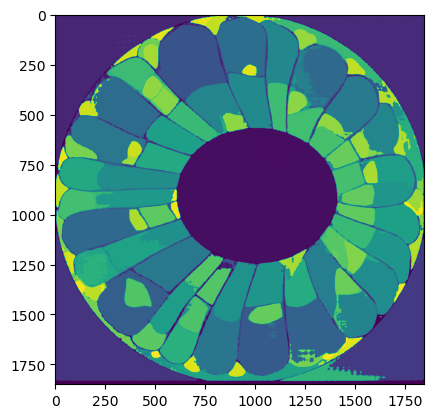

In [119]:
labels = np.zeros(image.shape[:2], dtype=np.uint16)

labels = make_label_image(labels, results, image.mean(axis=2), 0, 100000000, 0)

plt.imshow(labels)

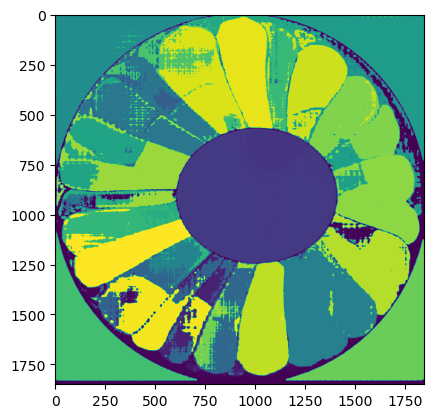

In [132]:
labels2 = np.zeros(image.shape[:2], dtype=np.uint16)

make_label_image2(labels2, results, image.mean(axis=2), 100000, 100000000, 0)

plt.imshow(labels2)

In [121]:
labels2.max()

242

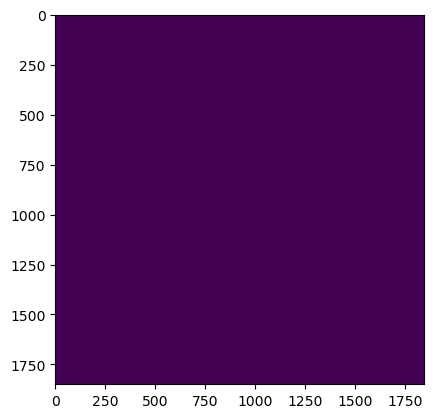

In [128]:
test=labels-labels2
test.max()
plt.imshow(test)

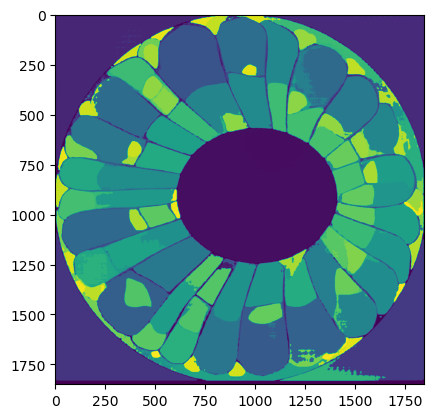

In [122]:
plt.imshow(labels2)

In [133]:
viewer = napari.Viewer()
viewer.add_image(image, name="image")
viewer.add_labels(labels, name="labels")
viewer.add_labels(labels2, name="labels2")
viewer.add_image(test, name = 'test')

<Image layer 'test' at 0x1e3b9b37520>

In [47]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU
    device = torch.device("cuda")
    print("Using GPU")
else:
    # Use the CPU instead
    device = torch.device("cpu")
    print("Using CPU")

# Example tensor creation
tensor = torch.rand(3, 3).to(device)

# Check if the tensor is on GPU
print("Tensor is on GPU:", tensor.is_cuda)

Using GPU
Tensor is on GPU: True


In [148]:
from skimage.measure import label
from skimage.measure import regionprops

for enum, result in enumerate(sorted_results):
        segmentation = result['segmentation']
        coords = np.where(segmentation)
        props = regionprops(segmentation.astype('uint8'))
        print(len(props))
        print(props[0].solidity)



1
0.965589061164693
1
0.6851750424250043
1
0.5020198114842614
1
0.4883137561210082
1
0.5893827022807115
1
0.45500326063328744
1
0.5754909508621427
1
0.5606102870726353
1
0.4232805270174888
1
0.3214525088371666
1
0.44451958298112143
1
0.6326927360725785
1
0.4888722975012311
1
0.6197220519108931
1
0.42879697323130317
1
0.6272851416237171
1
0.5905831839593146
1
0.5694415782739692
1
0.4911093826311886
1
0.7076416337285902
1
0.700056319897015
1
0.7501150029572189
1
0.43501889438622465
1
0.49375659918284903
1
0.6124249084249084
1
0.4625765226328254
1
0.6874892622753668
1
0.33905051505885164
1
0.823766741535646
1
0.44633519653804543
1
0.7538174139051332
1
0.6922318312850857
1
0.6065442936951316
1
0.7406130268199234
1
0.4888598385813345
1
0.6836615520921429
1
0.40225198530283274
1
0.6276558824663556
1
0.6935791757049892
1
0.5836834864091027
1
0.7088170259812051
1
0.8032151646855527
1
0.679809909189291
1
0.30085285132382894
1
0.4173067690830533
1
0.5385633638310298
1
0.7561648463010923
1
0.4803